In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix
from pandas import set_option
from pandas import read_csv
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
import statsmodels.api as sm
from matplotlib import pyplot
from scipy import interp

from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
import pandas as pd 


import numpy as np # linear algebra

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from  sklearn.model_selection import train_test_split

pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', True)
pd.set_option('max_colwidth', 80)

## Read Data

In [4]:
#Read the dataset

aisles = read_csv("aisles.csv") 
departments = read_csv("departments.csv") 
order_products__prior = read_csv("order_products__prior.csv")
order_products__train = read_csv("order_products__train.csv") 
orders = read_csv("orders.csv") 
products = read_csv("products.csv") 
sample_submission = read_csv("sample_submission.csv") 

In [5]:
aisles.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [6]:
departments.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [7]:
order_products__train.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [8]:
order_products__prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [9]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [10]:
products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni With Vodka Cream Sauce,38,1
4,5,Green Chile Anytime Sauce,5,13


In [9]:
sample_submission.head()

,order_id,products
0,17,39276 29259
1,34,39276 29259
2,137,39276 29259
3,182,39276 29259
4,257,39276 29259


## Data Wrangling and Creating Features

In [11]:
# Remove users with 'test' eval_set. Their final orders are not labeled  with the detail.  Thus note usabel

In [12]:
exclude_user_id = orders[orders['eval_set'] == 'test'].user_id.unique()
exclude_user_id = pd.DataFrame({'user_id':exclude_user_id})

In [13]:
exclude_orders = pd.merge(orders, exclude_user_id, how='inner', on=['user_id'])
order_products__prior = (order_products__prior[~order_products__prior.order_id.isin(exclude_orders.order_id)])
orders = (orders[~orders.order_id.isin(exclude_orders.order_id)])

In [14]:
orders[orders['eval_set'] == 'test'].user_id.unique()

array([], dtype=int64)

In [15]:
# Buld our data set.

In [16]:
#reordered on 'train' orders
data_yesOrderLast  = pd.merge(order_products__train, products, how='inner', on=['product_id'])
data_yesOrderLast  = pd.merge(data_yesOrderLast, orders, how='inner', on=['order_id'])
data_yesOrderLast = data_yesOrderLast.groupby(['user_id', 'product_id', 'order_id'])['order_number'].count().reset_index()
data_yesOrderLast.columns = ['user_id', 'product_id', 'order_id', 'reordered']

In [17]:
#user,item reorder count (i.e how many times they ordered the item in the past)
data_t1  = pd.merge(order_products__prior, products, how='inner', on=['product_id'])
data_t1  = pd.merge(data_t1, orders, how='inner', on=['order_id'])
data_t1 = data_t1.groupby(['user_id', 'product_id'])['order_id'].count().reset_index()
data_t1.columns = ['user_id', 'product_id', 'reorder_count']


In [18]:
#user, prior order count (i.e how many times they make any order)
data_t2 = pd.merge(order_products__prior, orders, how='inner', on=['order_id'])
data_t2 = data_t2.groupby(['user_id'])['order_number'].max().reset_index()
data_t2.columns = ['user_id', 'prior_ordercount']

In [19]:
# Add more features here based on prior data

In [20]:
# temp data
data_t3a = pd.merge(order_products__prior, orders[orders['eval_set']=='prior'], how='inner', on=['order_id'])
data_t3b = pd.merge(order_products__train, orders[orders['eval_set']=='train'], how='inner', on=['order_id'])
data_t3 = pd.concat([data_t3a, data_t3b])   

In [21]:
data_t3 = data_t3.sort_values(by=['user_id','product_id', 'order_number'])

In [22]:
data_t3t =  pd.merge(data_t3, data_t2, how='inner', on=['user_id'])

In [23]:
data_t3t['orderedAtLastOne'] = data_t3t['prior_ordercount'] == data_t3t['order_number']
data_t3t['orderedAtLastTwo'] = data_t3t['prior_ordercount']-1 == data_t3t['order_number']
data_t3t['orderedAtLastThree'] = data_t3t['prior_ordercount']-2 == data_t3t['order_number']

In [24]:
# User ordered the product at Train order - 1
data_t4 = data_t3t.groupby(['user_id', 'product_id'])['orderedAtLastOne'].max().reset_index()
data_t4.columns = ['user_id', 'product_id', 'orderedAtLastOne']
data_t4.head()

,user_id,product_id,orderedAtLastOne
0,1,196,True
1,1,10258,True
2,1,10326,False
3,1,12427,True
4,1,13032,True


In [25]:
# User ordered the product at Train order - 2
data_t5 = data_t3t.groupby(['user_id', 'product_id'])['orderedAtLastTwo'].max().reset_index()
data_t5.columns = ['user_id', 'product_id', 'orderedAtLastTwo']
data_t5.head()

,user_id,product_id,orderedAtLastTwo
0,1,196,True
1,1,10258,True
2,1,10326,False
3,1,12427,True
4,1,13032,False


In [26]:
# User ordered the product at Train order - 3
data_t6 = data_t3t.groupby(['user_id', 'product_id'])['orderedAtLastThree'].max().reset_index()
data_t6.columns = ['user_id', 'product_id', 'orderedAtLastThree']
data_t6.head()

,user_id,product_id,orderedAtLastThree
0,1,196,True
1,1,10258,True
2,1,10326,False
3,1,12427,True
4,1,13032,False


In [27]:
# User's average day prior orders
data_t7 = orders[orders['eval_set']=='prior'].groupby(['user_id'])['days_since_prior_order'].mean().reset_index()
data_t7.columns = ['user_id', 'avg_days_since_prior_order']
data_t7.head()

,user_id,avg_days_since_prior_order
0,1,19.555556
1,2,15.230769
2,5,13.333333
3,7,10.684211
4,8,30.000000


In [28]:
# Average add to cart order
data_t8 = data_t3t.groupby(['user_id', 'product_id'])['add_to_cart_order'].mean().reset_index()
data_t8.columns = ['user_id', 'product_id', 'avg_add_to_cart_order']
data_t8.head()

,user_id,product_id,avg_add_to_cart_order
0,1,196,1.363636
1,1,10258,3.600000
2,1,10326,5.000000
3,1,12427,3.300000
4,1,13032,6.500000


In [29]:
# Start combining the data
data_prior =  pd.merge(data_t1, data_t2, how='inner', on=['user_id'])
data_prior.head()

,user_id,product_id,reorder_count,prior_ordercount
0,1,196,10,10
1,1,10258,9,10
2,1,10326,1,10
3,1,12427,10,10
4,1,13032,3,10


In [30]:
data_prior =  pd.merge(data_prior, data_t4, how='inner', on=['user_id', 'product_id'])
data_prior.head()

,user_id,product_id,reorder_count,prior_ordercount,orderedAtLastOne
0,1,196,10,10,True
1,1,10258,9,10,True
2,1,10326,1,10,False
3,1,12427,10,10,True
4,1,13032,3,10,True


In [31]:
data_prior =  pd.merge(data_prior, data_t5, how='inner', on=['user_id', 'product_id'])
data_prior.head()

,user_id,product_id,reorder_count,prior_ordercount,orderedAtLastOne,orderedAtLastTwo
0,1,196,10,10,True,True
1,1,10258,9,10,True,True
2,1,10326,1,10,False,False
3,1,12427,10,10,True,True
4,1,13032,3,10,True,False


In [32]:
data_prior =  pd.merge(data_prior, data_t6, how='inner', on=['user_id', 'product_id'])
data_prior.head()

,user_id,product_id,reorder_count,prior_ordercount,orderedAtLastOne,orderedAtLastTwo,orderedAtLastThree
0,1,196,10,10,True,True,True
1,1,10258,9,10,True,True,True
2,1,10326,1,10,False,False,False
3,1,12427,10,10,True,True,True
4,1,13032,3,10,True,False,False


In [33]:
data_prior =  pd.merge(data_prior, data_t7, how='inner', on=['user_id'])
data_prior.head()

,user_id,product_id,reorder_count,prior_ordercount,orderedAtLastOne,orderedAtLastTwo,orderedAtLastThree,avg_days_since_prior_order
0,1,196,10,10,True,True,True,19.555556
1,1,10258,9,10,True,True,True,19.555556
2,1,10326,1,10,False,False,False,19.555556
3,1,12427,10,10,True,True,True,19.555556
4,1,13032,3,10,True,False,False,19.555556


In [34]:
data_prior =  pd.merge(data_prior, data_t8, how='inner', on=['user_id', 'product_id'])
data_prior.head()

,user_id,product_id,reorder_count,prior_ordercount,orderedAtLastOne,orderedAtLastTwo,orderedAtLastThree,avg_days_since_prior_order,avg_add_to_cart_order
0,1,196,10,10,True,True,True,19.555556,1.363636
1,1,10258,9,10,True,True,True,19.555556,3.600000
2,1,10326,1,10,False,False,False,19.555556,5.000000
3,1,12427,10,10,True,True,True,19.555556,3.300000
4,1,13032,3,10,True,False,False,19.555556,6.500000


In [35]:
data = pd.merge(data_prior, data_yesOrderLast, how='left', on=['user_id', 'product_id'])
data[['reordered']] = data[['reordered']].fillna(value=0)
data.head()


,user_id,product_id,reorder_count,prior_ordercount,orderedAtLastOne,orderedAtLastTwo,orderedAtLastThree,avg_days_since_prior_order,avg_add_to_cart_order,order_id,reordered
0,1,196,10,10,True,True,True,19.555556,1.363636,1187899.0,1.0
1,1,10258,9,10,True,True,True,19.555556,3.600000,1187899.0,1.0
2,1,10326,1,10,False,False,False,19.555556,5.000000,NaN,0.0
3,1,12427,10,10,True,True,True,19.555556,3.300000,NaN,0.0
4,1,13032,3,10,True,False,False,19.555556,6.500000,1187899.0,1.0


In [36]:
data = pd.merge(data, products, how='left', on=['product_id'])
data = pd.merge(data, departments, how='left', on=['department_id'])
data = pd.merge(data, aisles, how='left', on=['aisle_id'])
data.head()

,user_id,product_id,reorder_count,prior_ordercount,orderedAtLastOne,orderedAtLastTwo,orderedAtLastThree,avg_days_since_prior_order,avg_add_to_cart_order,order_id,reordered,product_name,aisle_id,department_id,department,aisle
0,1,196,10,10,True,True,True,19.555556,1.363636,1187899.0,1.0,Soda,77,7,beverages,soft drinks
1,1,10258,9,10,True,True,True,19.555556,3.600000,1187899.0,1.0,Pistachios,117,19,snacks,nuts seeds dried fruit
2,1,10326,1,10,False,False,False,19.555556,5.000000,NaN,0.0,Organic Fuji Apples,24,4,produce,fresh fruits
3,1,12427,10,10,True,True,True,19.555556,3.300000,NaN,0.0,Original Beef Jerky,23,19,snacks,popcorn jerky
4,1,13032,3,10,True,False,False,19.555556,6.500000,1187899.0,1.0,Cinnamon Toast Crunch,121,14,breakfast,cereal


In [37]:
# Review the data (Test debug code)

In [38]:
prior_data = pd.merge(order_products__prior, orders[orders['eval_set']=='prior'], how='inner', on=['order_id'])
test_data_temp = pd.merge(order_products__train, orders[orders['eval_set']=='train'], how='inner', on=['order_id'])

In [39]:

t1 = prior_data[prior_data['user_id'] == 202279].sort_values(by=['product_id', 'order_number'])
t2 = test_data_temp[test_data_temp['user_id'] == 202279].sort_values(by=['product_id', 'order_number'])

t3 = pd.concat([t1, t2])   

In [40]:
t3.sort_values(by=['product_id', 'order_number'])

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order


In [41]:
t4 = (data[data['user_id'] == 202279]).sort_values(by=['product_id'])

In [42]:
t4.head()

,user_id,product_id,reorder_count,prior_ordercount,orderedAtLastOne,orderedAtLastTwo,orderedAtLastThree,avg_days_since_prior_order,avg_add_to_cart_order,order_id,reordered,product_name,aisle_id,department_id,department,aisle


In [43]:
# Set types

In [44]:
data['aisle_id'] = data['aisle_id'].astype('int')
data['department_id'] = data['department_id'].astype('int')
data['reordered'] = data['reordered'].astype('int')

## Create Training KFolds Set and Holdout

In [45]:
# Split data into train and hold out. For now use a small set to quickly run the experiments.
trainUserIDs = orders[orders['eval_set']=='prior'].user_id.unique()
userTrain, otherData = train_test_split(trainUserIDs,test_size = 0.99,  random_state=42)
#userTrain, otherData = train_test_split(trainUserIDs,test_size = 0.75,  random_state=42)
userTrainDF = pd.DataFrame({'user_id':userTrain})


trainData = pd.merge(data, userTrainDF[['user_id']], how='inner', on=['user_id'])


userTest, notUsed = train_test_split(otherData, test_size = 0.99,  random_state=42)
#userTest, notUsed = train_test_split(otherData, test_size = 0.7,  random_state=42)
userTestDF = pd.DataFrame({'user_id':userTest})

testData = pd.merge(data, userTestDF[['user_id']], how='inner', on=['user_id'])


In [46]:
trainData.shape

(27011, 16)

In [47]:
trainData.dtypes

user_id                         int64
product_id                      int64
reorder_count                   int64
prior_ordercount                int64
orderedAtLastOne                 bool
orderedAtLastTwo                 bool
orderedAtLastThree               bool
avg_days_since_prior_order    float64
avg_add_to_cart_order         float64
order_id                      float64
reordered                       int32
product_name                   object
aisle_id                        int32
department_id                   int32
department                     object
aisle                          object
dtype: object

In [48]:
trainData.shape

(27011, 16)

## Exploratory Data Analysis

## Feature Selection

In [49]:

print(trainData.columns)

Index(['user_id', 'product_id', 'reorder_count', 'prior_ordercount',
       'orderedAtLastOne', 'orderedAtLastTwo', 'orderedAtLastThree',
       'avg_days_since_prior_order', 'avg_add_to_cart_order', 'order_id',
       'reordered', 'product_name', 'aisle_id', 'department_id', 'department',
       'aisle'],
      dtype='object')


In [50]:
# TEAM: Experiment Models
#selectFeatures = ['product_id',  'aisle_id', 'department_id', 'prior_ordercount', 'reorder_count']
selectFeatures = [ 'aisle_id', 'department_id', 'prior_ordercount', 'reorder_count', 'orderedAtLastOne', \
                    'orderedAtLastTwo', 'orderedAtLastThree', 'avg_days_since_prior_order', 'avg_add_to_cart_order']
outputVariable = ['reordered']




In [51]:
X = trainData[selectFeatures]
Y = trainData[outputVariable]


In [52]:
X.head()

,aisle_id,department_id,prior_ordercount,reorder_count,orderedAtLastOne,orderedAtLastTwo,orderedAtLastThree,avg_days_since_prior_order,avg_add_to_cart_order
0,114,17,4,1,False,True,False,24.666667,9.000000
1,112,3,4,1,False,False,True,24.666667,9.000000
2,73,11,4,1,False,True,False,24.666667,7.000000
3,96,20,4,3,False,True,True,24.666667,2.666667
4,128,3,4,1,False,True,False,24.666667,1.500000


In [53]:
Y.dtypes

reordered    int32
dtype: object

## Model Comparision, ROC

In [54]:
# TEAM: Experiment Models
models = []

models.append(('Dummy', DummyClassifier(strategy='most_frequent',random_state=0)))
#models.append(('RandomForest1', RandomForestClassifier(n_estimators=100, max_depth = 2, random_state=42)))
#models.append(('RandomForest2', RandomForestClassifier(n_estimators=100, max_depth = 3, random_state=42)))
#models.append(('RandomForest3', RandomForestClassifier(n_estimators=100, max_depth = 4, random_state=42)))
#models.append(('RandomForest4', RandomForestClassifier(n_estimators=100, max_depth = 5, random_state=42)))
#models.append(('RandomForest5', RandomForestClassifier(n_estimators=100, max_depth = 6, random_state=42)))
models.append(('RandomForest', RandomForestClassifier(n_estimators=100, max_depth = 3, random_state=42)))
#models.append(('RandomForest7', RandomForestClassifier(n_estimators=100, max_depth = 8, random_state=42)))
#models.append(('RandomForest8', RandomForestClassifier(n_estimators=100, max_depth = 9, random_state=42)))
models.append(('AdaBoost', AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), n_estimators=100, algorithm="SAMME.R", learning_rate=.75,random_state=42)))
models.append(('XGBoost',XGBClassifier(learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=5, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27)))
'''
models.append(('XGBoost2',XGBClassifier(learning_rate =0.1, n_estimators=140, max_depth=4,
 min_child_weight=5, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27)))
models.append(('XGBoost3',XGBClassifier(learning_rate =0.1, n_estimators=140, max_depth=6,
 min_child_weight=5, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27)))
models.append(('XGBoost4',XGBClassifier(learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=4, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27)))
models.append(('XGBoost5',XGBClassifier(learning_rate =0.1, n_estimators=140, max_depth=4,
 min_child_weight=4, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27)))
models.append(('XGBoost6',XGBClassifier(learning_rate =0.1, n_estimators=140, max_depth=6,
 min_child_weight=4, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27)))
'''

"\nmodels.append(('XGBoost2',XGBClassifier(learning_rate =0.1, n_estimators=140, max_depth=4,\n min_child_weight=5, gamma=0, subsample=0.8, colsample_bytree=0.8,\n objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27)))\nmodels.append(('XGBoost3',XGBClassifier(learning_rate =0.1, n_estimators=140, max_depth=6,\n min_child_weight=5, gamma=0, subsample=0.8, colsample_bytree=0.8,\n objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27)))\nmodels.append(('XGBoost4',XGBClassifier(learning_rate =0.1, n_estimators=140, max_depth=5,\n min_child_weight=4, gamma=0, subsample=0.8, colsample_bytree=0.8,\n objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27)))\nmodels.append(('XGBoost5',XGBClassifier(learning_rate =0.1, n_estimators=140, max_depth=4,\n min_child_weight=4, gamma=0, subsample=0.8, colsample_bytree=0.8,\n objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27)))\nmodels.append(('XGBoost6',XGBClassifier(learning_rate =0.1, n

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Dummy: 0.909889 (0.013059)
RandomForest: 0.912000 (0.013493)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


AdaBoost: 0.914369 (0.010906)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


XGBoost: 0.913036 (0.013027)


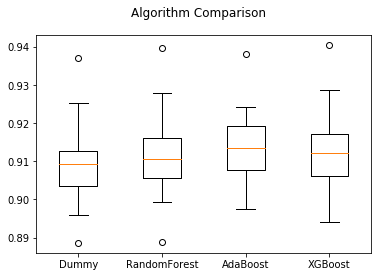

In [55]:
from sklearn.utils import check_X_y

# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
#scoring = 'roc_auc'

for name, model in models:
    kfold = KFold(n_splits=10, random_state=7)
    #Bug with dummy. Suggested by https://github.com/scikit-learn/scikit-learn/issues/10786
    X_converted, y_converted = check_X_y(X=X, y=Y)
    cv_results = cross_val_score(model, X_converted, y_converted, cv=kfold, scoring=scoring)

    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
    
## boxplot algorithm comparison
fig = pyplot.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

In [56]:

#https://www.kaggle.com/kanncaa1/roc-curve-with-k-fold-cv 
X_converted, y_converted = check_X_y(X=X, y=Y)

mean_fpr = dict()
mean_tpr = dict()
mean_auc = dict()

for name, model in models:
    tprs = []
    aucs = []
    mean_fpr[name] = np.linspace(0,1,100)
    i = 1
    kfold = KFold(n_splits=10, random_state=7)

    for train,test in kfold.split(X_converted,y_converted):
        prediction = model.fit(X_converted[train],y_converted[train]).predict_proba(X_converted[test])
        fpr, tpr, thres = roc_curve(y_converted[test], prediction[:, 1])
        tprs.append(interp(mean_fpr[name], fpr, tpr))
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        i= i+1

    mean_tpr[name] = np.mean(tprs, axis=0)
    mean_auc[name] = auc(mean_fpr[name], mean_tpr[name])
    #model.fit(X_converted, y_converted)
    if (name == 'Dummy'):
        model.fit(X_converted, y_converted)
    else:
        model.fit(X, Y)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = colum

auc Dummy:0.5
auc RandomForest:0.8137645030744793
auc AdaBoost:0.8205620769596851
auc XGBoost:0.8330803250628718


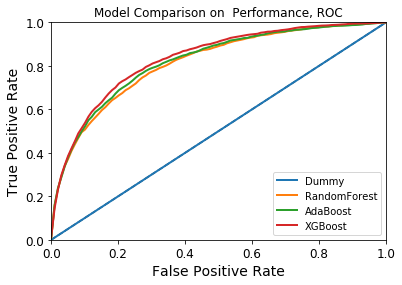

In [57]:
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12


fig, ax = plt.subplots()
ax.plot([0, 1], [0, 1], 'k--')
plt.axis([0, 1, 0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

for name, model in models:
    ax.plot(mean_fpr[name], mean_tpr[name], linewidth=2, label = name)
    print("auc " + name + ":" + str(mean_auc[name]))
    
    
plt.title('Model Comparison on  Performance, ROC')
plt.legend(loc="best")
plt.show()


## F1 Score on Hold out Set

In [58]:
X_test = testData[selectFeatures]
y_test = testData[outputVariable]

for name, model in models:
    y_pred = model.predict(X_test)
    #y_pred = (model.predict_proba(X_test)[:,1] >= 0.33).astype(bool) # set threshold as 0.3
    
    print("model name:" + name)
    print("F1 score :" + str(f1_score(y_test, y_pred, average="macro")))
    print("Precision score:" + str(precision_score(y_test, y_pred, average="macro")))
    print("Recall score:" + str(recall_score(y_test, y_pred, average="macro")))
    
    unique_elements, counts_elements = np.unique(y_pred, return_counts=True)
    print("Frequency of unique values of the predicated array:")
    print(np.asarray((unique_elements, counts_elements)))
    print("")
    
    print(confusion_matrix(y_test, y_pred))  
    print(classification_report(y_test, y_pred))  



model name:Dummy
F1 score :0.4739325462316449
Precision score:0.4504484575473595
Recall score:0.5
Frequency of unique values of the predicated array:
[[    0]
 [24863]]

[[22399     0]
 [ 2464     0]]
              precision    recall  f1-score   support

           0       0.90      1.00      0.95     22399
           1       0.00      0.00      0.00      2464

   micro avg       0.90      0.90      0.90     24863
   macro avg       0.45      0.50      0.47     24863
weighted avg       0.81      0.90      0.85     24863

model name:RandomForest
F1 score :0.5271667413395635
Precision score:0.8206104963217713
Recall score:0.5270900475757556
Frequency of unique values of the predicated array:
[[    0     1]
 [24674   189]]

[[22349    50]
 [ 2325   139]]


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib

              precision    recall  f1-score   support

           0       0.91      1.00      0.95     22399
           1       0.74      0.06      0.10      2464

   micro avg       0.90      0.90      0.90     24863
   macro avg       0.82      0.53      0.53     24863
weighted avg       0.89      0.90      0.87     24863

model name:AdaBoost
F1 score :0.6169668244775368
Precision score:0.756054046388972
Recall score:0.5861766371324555
Frequency of unique values of the predicated array:
[[    0     1]
 [24092   771]]

[[22087   312]
 [ 2005   459]]
              precision    recall  f1-score   support

           0       0.92      0.99      0.95     22399
           1       0.60      0.19      0.28      2464

   micro avg       0.91      0.91      0.91     24863
   macro avg       0.76      0.59      0.62     24863
weighted avg       0.88      0.91      0.88     24863

model name:XGBoost
F1 score :0.6139583309104275
Precision score:0.7601807367509338
Recall score:0.5836015768908979
F

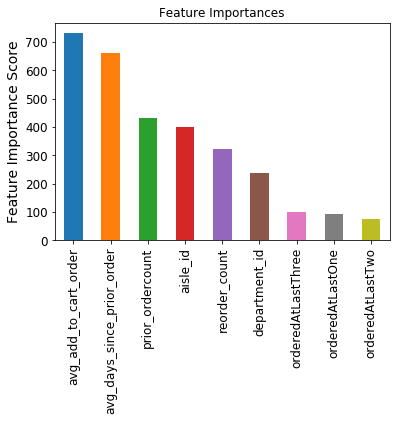

In [59]:
for name, model in models:
    if (name == 'XGBoost'):
        feat_imp = pd.Series(model.get_booster().get_fscore()).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')

## Repeat, but focus on XGBoost and add Penality because the target class is so imbalance

In [60]:
# TEAM: Experiment Models
#https://stats.stackexchange.com/questions/28029/training-a-decision-tree-against-unbalanced-data
models = []

X_converted, y_converted = check_X_y(X=X, y=Y)

models.append(('Dummy', DummyClassifier(strategy='most_frequent',random_state=0)))
models.append(('XGBoost',XGBClassifier(learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=5, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27)))

pos_weight = sum(y_converted==0)/sum(y_converted==1)
models.append(('XGBoostWeight',XGBClassifier(learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=5, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=pos_weight, seed=27)))


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [61]:

#https://www.kaggle.com/kanncaa1/roc-curve-with-k-fold-cv 
X_converted, y_converted = check_X_y(X=X, y=Y)

mean_fpr = dict()
mean_tpr = dict()
mean_auc = dict()

for name, model in models:
    tprs = []
    aucs = []
    mean_fpr[name] = np.linspace(0,1,100)
    i = 1
    kfold = KFold(n_splits=10, random_state=7)

    for train,test in kfold.split(X_converted,y_converted):
        prediction = model.fit(X_converted[train],y_converted[train]).predict_proba(X_converted[test])
        fpr, tpr, thres = roc_curve(y_converted[test], prediction[:, 1])
        tprs.append(interp(mean_fpr[name], fpr, tpr))
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        i= i+1

    mean_tpr[name] = np.mean(tprs, axis=0)
    mean_auc[name] = auc(mean_fpr[name], mean_tpr[name])
    #model.fit(X_converted, y_converted)
    if (name == 'Dummy'):
        model.fit(X_converted, y_converted)
    else:
        model.fit(X, Y)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_sam

auc Dummy:0.5
auc XGBoost:0.8330803250628718
auc XGBoostWeight:0.8357549754398257


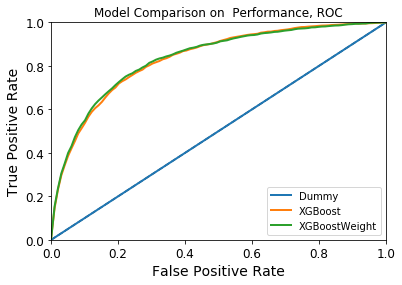

In [65]:
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12


fig, ax = plt.subplots()
ax.plot([0, 1], [0, 1], 'k--')
plt.axis([0, 1, 0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

for name, model in models:
    ax.plot(mean_fpr[name], mean_tpr[name], linewidth=2, label = name)
    print("auc " + name + ":" + str(mean_auc[name]))
    
    
plt.title('Model Comparison on  Performance, ROC')
plt.legend(loc="best")
plt.show()


In [66]:
X_test = testData[selectFeatures]
y_test = testData[outputVariable]

for name, model in models:
    y_pred = model.predict(X_test)
    #y_pred = (model.predict_proba(X_test)[:,1] >= 0.33).astype(bool) # set threshold as 0.3
    
    #default
    print("model name:" + name)
    print("F1 score :" + str(f1_score(y_test, y_pred, average="macro")))
    print("Precision score:" + str(precision_score(y_test, y_pred, average="macro")))
    print("Recall score:" + str(recall_score(y_test, y_pred, average="macro")))
    
    unique_elements, counts_elements = np.unique(y_pred, return_counts=True)
    print("Frequency of unique values of the predicated array:")
    print(np.asarray((unique_elements, counts_elements)))
    print("")
    
    print(confusion_matrix(y_test, y_pred))  
    print(classification_report(y_test, y_pred))  

model name:Dummy
F1 score :0.4739325462316449
Precision score:0.4504484575473595
Recall score:0.5
Frequency of unique values of the predicated array:
[[    0]
 [24863]]

[[22399     0]
 [ 2464     0]]
              precision    recall  f1-score   support

           0       0.90      1.00      0.95     22399
           1       0.00      0.00      0.00      2464

   micro avg       0.90      0.90      0.90     24863
   macro avg       0.45      0.50      0.47     24863
weighted avg       0.81      0.90      0.85     24863

model name:XGBoost
F1 score :0.6139583309104275
Precision score:0.7601807367509338
Recall score:0.5836015768908979
Frequency of unique values of the predicated array:
[[    0     1]
 [24128   735]]

[[22108   291]
 [ 2020   444]]
              precision    recall  f1-score   support

           0       0.92      0.99      0.95     22399
           1       0.60      0.18      0.28      2464

   micro avg       0.91      0.91      0.91     24863
   macro avg       0.76 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib

model name:XGBoostWeight
F1 score :0.6521498595074998
Precision score:0.630301205555894
Recall score:0.7594947674206235
Frequency of unique values of the predicated array:
[[    0     1]
 [19112  5751]]

[[18370  4029]
 [  742  1722]]
              precision    recall  f1-score   support

           0       0.96      0.82      0.89     22399
           1       0.30      0.70      0.42      2464

   micro avg       0.81      0.81      0.81     24863
   macro avg       0.63      0.76      0.65     24863
weighted avg       0.90      0.81      0.84     24863



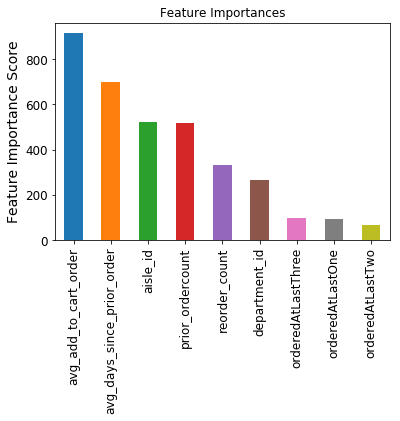

In [67]:
for name, model in models:
    if (name == 'XGBoostWeight'):
        feat_imp = pd.Series(model.get_booster().get_fscore()).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')

### Study the Recall / Threshold tradeoff

In [68]:
from sklearn.metrics import precision_recall_curve

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib

model name:Dummy
threshold:0.0
F1 score :0.09016723387126285
Precision score:0.04955154245264047
Recall score:0.5
Frequency of unique values of the predicated array:
[[    1]
 [24863]]

[[    0 22399]
 [    0  2464]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     22399
           1       0.10      1.00      0.18      2464

   micro avg       0.10      0.10      0.10     24863
   macro avg       0.05      0.50      0.09     24863
weighted avg       0.01      0.10      0.02     24863

model name:Dummy
threshold:0.05
F1 score :0.4739325462316449
Precision score:0.4504484575473595
Recall score:0.5
Frequency of unique values of the predicated array:
[[    0]
 [24863]]

[[22399     0]
 [ 2464     0]]
              precision    recall  f1-score   support

           0       0.90      1.00      0.95     22399
           1       0.00      0.00      0.00      2464

   micro avg       0.90      0.90      0.90     24863
   macro avg       0.4

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib

model name:Dummy
threshold:0.1
F1 score :0.4739325462316449
Precision score:0.4504484575473595
Recall score:0.5
Frequency of unique values of the predicated array:
[[    0]
 [24863]]

[[22399     0]
 [ 2464     0]]
              precision    recall  f1-score   support

           0       0.90      1.00      0.95     22399
           1       0.00      0.00      0.00      2464

   micro avg       0.90      0.90      0.90     24863
   macro avg       0.45      0.50      0.47     24863
weighted avg       0.81      0.90      0.85     24863

model name:Dummy
threshold:0.15000000000000002
F1 score :0.4739325462316449
Precision score:0.4504484575473595
Recall score:0.5
Frequency of unique values of the predicated array:
[[    0]
 [24863]]

[[22399     0]
 [ 2464     0]]
              precision    recall  f1-score   support

           0       0.90      1.00      0.95     22399
           1       0.00      0.00      0.00      2464

   micro avg       0.90      0.90      0.90     24863
   macro 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



              precision    recall  f1-score   support

           0       0.90      1.00      0.95     22399
           1       0.00      0.00      0.00      2464

   micro avg       0.90      0.90      0.90     24863
   macro avg       0.45      0.50      0.47     24863
weighted avg       0.81      0.90      0.85     24863

model name:Dummy
threshold:0.35000000000000003
F1 score :0.4739325462316449
Precision score:0.4504484575473595
Recall score:0.5
Frequency of unique values of the predicated array:
[[    0]
 [24863]]

[[22399     0]
 [ 2464     0]]
              precision    recall  f1-score   support

           0       0.90      1.00      0.95     22399
           1       0.00      0.00      0.00      2464

   micro avg       0.90      0.90      0.90     24863
   macro avg       0.45      0.50      0.47     24863
weighted avg       0.81      0.90      0.85     24863

model name:Dummy
threshold:0.4
F1 score :0.4739325462316449
Precision score:0.4504484575473595
Recall score:0.5
Fr

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\

model name:Dummy
threshold:0.45
F1 score :0.4739325462316449
Precision score:0.4504484575473595
Recall score:0.5
Frequency of unique values of the predicated array:
[[    0]
 [24863]]

[[22399     0]
 [ 2464     0]]
              precision    recall  f1-score   support

           0       0.90      1.00      0.95     22399
           1       0.00      0.00      0.00      2464

   micro avg       0.90      0.90      0.90     24863
   macro avg       0.45      0.50      0.47     24863
weighted avg       0.81      0.90      0.85     24863

model name:Dummy
threshold:0.5
F1 score :0.4739325462316449
Precision score:0.4504484575473595
Recall score:0.5
Frequency of unique values of the predicated array:
[[    0]
 [24863]]

[[22399     0]
 [ 2464     0]]
              precision    recall  f1-score   support

           0       0.90      1.00      0.95     22399
           1       0.00      0.00      0.00      2464

   micro avg       0.90      0.90      0.90     24863
   macro avg       0.45 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[[22399     0]
 [ 2464     0]]
              precision    recall  f1-score   support

           0       0.90      1.00      0.95     22399
           1       0.00      0.00      0.00      2464

   micro avg       0.90      0.90      0.90     24863
   macro avg       0.45      0.50      0.47     24863
weighted avg       0.81      0.90      0.85     24863

model name:Dummy
threshold:0.6000000000000001
F1 score :0.4739325462316449
Precision score:0.4504484575473595
Recall score:0.5
Frequency of unique values of the predicated array:
[[    0]
 [24863]]

[[22399     0]
 [ 2464     0]]
              precision    recall  f1-score   support

           0       0.90      1.00      0.95     22399
           1       0.00      0.00      0.00      2464

   micro avg       0.90      0.90      0.90     24863
   macro avg       0.45      0.50      0.47     24863
weighted avg       0.81      0.90      0.85     24863

model name:Dummy
threshold:0.65
F1 score :0.4739325462316449
Precision score:0.450448

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib

model name:Dummy
threshold:0.7000000000000001
F1 score :0.4739325462316449
Precision score:0.4504484575473595
Recall score:0.5
Frequency of unique values of the predicated array:
[[    0]
 [24863]]

[[22399     0]
 [ 2464     0]]
              precision    recall  f1-score   support

           0       0.90      1.00      0.95     22399
           1       0.00      0.00      0.00      2464

   micro avg       0.90      0.90      0.90     24863
   macro avg       0.45      0.50      0.47     24863
weighted avg       0.81      0.90      0.85     24863

model name:Dummy
threshold:0.75
F1 score :0.4739325462316449
Precision score:0.4504484575473595
Recall score:0.5
Frequency of unique values of the predicated array:
[[    0]
 [24863]]

[[22399     0]
 [ 2464     0]]
              precision    recall  f1-score   support

           0       0.90      1.00      0.95     22399
           1       0.00      0.00      0.00      2464

   micro avg       0.90      0.90      0.90     24863
   macro 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[[22399     0]
 [ 2464     0]]
              precision    recall  f1-score   support

           0       0.90      1.00      0.95     22399
           1       0.00      0.00      0.00      2464

   micro avg       0.90      0.90      0.90     24863
   macro avg       0.45      0.50      0.47     24863
weighted avg       0.81      0.90      0.85     24863

model name:Dummy
threshold:0.8500000000000001
F1 score :0.4739325462316449
Precision score:0.4504484575473595
Recall score:0.5
Frequency of unique values of the predicated array:
[[    0]
 [24863]]

[[22399     0]
 [ 2464     0]]
              precision    recall  f1-score   support

           0       0.90      1.00      0.95     22399
           1       0.00      0.00      0.00      2464

   micro avg       0.90      0.90      0.90     24863
   macro avg       0.45      0.50      0.47     24863
weighted avg       0.81      0.90      0.85     24863

model name:Dummy
threshold:0.9
F1 score :0.4739325462316449
Precision score:0.4504484

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.90      1.00      0.95     22399
           1       0.00      0.00      0.00      2464

   micro avg       0.90      0.90      0.90     24863
   macro avg       0.45      0.50      0.47     24863
weighted avg       0.81      0.90      0.85     24863

model name:Dummy
threshold:0.9500000000000001
F1 score :0.4739325462316449
Precision score:0.4504484575473595
Recall score:0.5
Frequency of unique values of the predicated array:
[[    0]
 [24863]]

[[22399     0]
 [ 2464     0]]
              precision    recall  f1-score   support

           0       0.90      1.00      0.95     22399
           1       0.00      0.00      0.00      2464

   micro avg       0.90      0.90      0.90     24863
   macro avg       0.45      0.50      0.47     24863
weighted avg       0.81      0.90      0.85     24863

model name:Dummy
threshold:1.0
F1 score :0.4739325462316449
Precision score:0.4504484575473595
Recall score:0.5
Freq

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


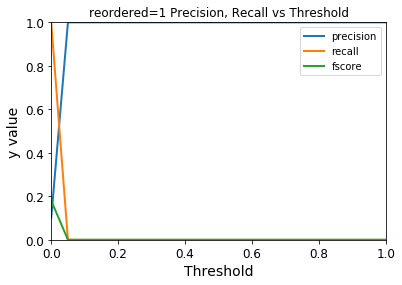

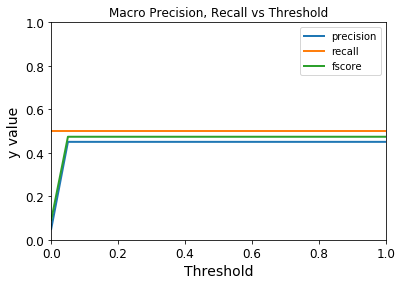

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib

model name:XGBoost
threshold:0.0
F1 score :0.09016723387126285
Precision score:0.04955154245264047
Recall score:0.5
Frequency of unique values of the predicated array:
[[    1]
 [24863]]

[[    0 22399]
 [    0  2464]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     22399
           1       0.10      1.00      0.18      2464

   micro avg       0.10      0.10      0.10     24863
   macro avg       0.05      0.50      0.09     24863
weighted avg       0.01      0.10      0.02     24863

model name:XGBoost
threshold:0.05
F1 score :0.5468440633854376
Precision score:0.5899951569057008
Recall score:0.7456471361633144
Frequency of unique values of the predicated array:
[[    0     1]
 [14405 10458]]

[[14068  8331]
 [  337  2127]]
              precision    recall  f1-score   support

           0       0.98      0.63      0.76     22399
           1       0.20      0.86      0.33      2464

   micro avg       0.65      0.65      0.65  

 [ 2367    97]]
              precision    recall  f1-score   support

           0       0.90      1.00      0.95     22399
           1       0.72      0.04      0.07      2464

   micro avg       0.90      0.90      0.90     24863
   macro avg       0.81      0.52      0.51     24863
weighted avg       0.89      0.90      0.86     24863

model name:XGBoost
threshold:0.8
F1 score :0.4962796433948325
Precision score:0.8103965901625776
Recall score:0.5108725430112546
Frequency of unique values of the predicated array:
[[    0     1]
 [24785    78]]

[[22377    22]
 [ 2408    56]]
              precision    recall  f1-score   support

           0       0.90      1.00      0.95     22399
           1       0.72      0.02      0.04      2464

   micro avg       0.90      0.90      0.90     24863
   macro avg       0.81      0.51      0.50     24863
weighted avg       0.88      0.90      0.86     24863

model name:XGBoost
threshold:0.8500000000000001
F1 score :0.4840760366653278
Precision

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib

model name:XGBoost
threshold:1.0
F1 score :0.4739325462316449
Precision score:0.4504484575473595
Recall score:0.5
Frequency of unique values of the predicated array:
[[    0]
 [24863]]

[[22399     0]
 [ 2464     0]]
              precision    recall  f1-score   support

           0       0.90      1.00      0.95     22399
           1       0.00      0.00      0.00      2464

   micro avg       0.90      0.90      0.90     24863
   macro avg       0.45      0.50      0.47     24863
weighted avg       0.81      0.90      0.85     24863



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


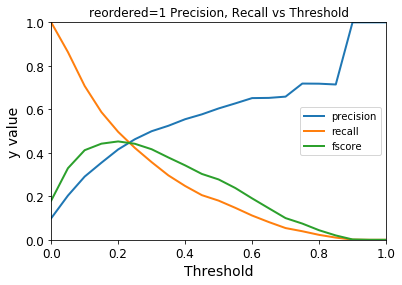

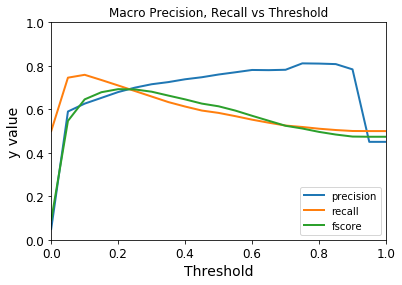

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib

model name:XGBoostWeight
threshold:0.0
F1 score :0.09016723387126285
Precision score:0.04955154245264047
Recall score:0.5
Frequency of unique values of the predicated array:
[[    1]
 [24863]]

[[    0 22399]
 [    0  2464]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     22399
           1       0.10      1.00      0.18      2464

   micro avg       0.10      0.10      0.10     24863
   macro avg       0.05      0.50      0.09     24863
weighted avg       0.01      0.10      0.02     24863

model name:XGBoostWeight
threshold:0.05
F1 score :0.19316367555107172
Precision score:0.5526318046672963
Recall score:0.5505867554529046
Frequency of unique values of the predicated array:
[[    0     1]
 [ 2357 22506]]

[[ 2348 20051]
 [    9  2455]]
              precision    recall  f1-score   support

           0       1.00      0.10      0.19     22399
           1       0.11      1.00      0.20      2464

   micro avg       0.19      0.1

F1 score :0.7001126592596503
Precision score:0.7111535926911075
Recall score:0.6905954608363198
Frequency of unique values of the predicated array:
[[    0     1]
 [22665  2198]]

[[21265  1134]
 [ 1400  1064]]
              precision    recall  f1-score   support

           0       0.94      0.95      0.94     22399
           1       0.48      0.43      0.46      2464

   micro avg       0.90      0.90      0.90     24863
   macro avg       0.71      0.69      0.70     24863
weighted avg       0.89      0.90      0.90     24863

model name:XGBoostWeight
threshold:0.8
F1 score :0.679612079978057
Precision score:0.7246541637652223
Recall score:0.65326829837313
Frequency of unique values of the predicated array:
[[    0     1]
 [23243  1620]]

[[21620   779]
 [ 1623   841]]
              precision    recall  f1-score   support

           0       0.93      0.97      0.95     22399
           1       0.52      0.34      0.41      2464

   micro avg       0.90      0.90      0.90     248

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib

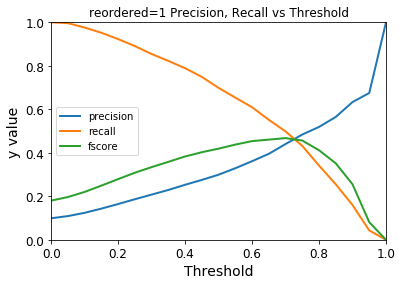

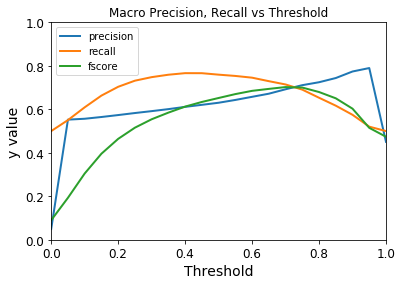

In [69]:
from sklearn.metrics import precision_recall_fscore_support

X_test = testData[selectFeatures]
y_test = testData[outputVariable]

#thresholds_tests = [.2, .3, .4, .5, .6, .7, .8, .9]
thresholds_tests = np.arange(0,1.05,0.05)

one_recall = []
one_precision = [];
one_fscore = []

recall_macro = []
precision_macro = [];
precision_fscore = []

for name, model in models:
    
    one_recall = []
    one_precision = [];
    one_fscore = []

    
    recall_macro = []
    precision_macro = [];
    fscore_macro = []

    for threshold in thresholds_tests:
        #y_pred = model.predict(X_test)
        y_pred = (model.predict_proba(X_test)[:,1] >= threshold).astype(bool) # set threshold as 0.3
        precision,recall,fscore,support=precision_recall_fscore_support(y_test,y_pred,average=None)
        
        precisionM,recallM,fscoreM,supportM=precision_recall_fscore_support(y_test,y_pred,average='macro')

        if (recall[1] < 0.01):
            one_precision.append(1)
        else:    
            one_precision.append((precision[1]))
        one_recall.append((recall[1]))
        one_fscore.append((fscore[1]))

        #print(fscore[1])
        
        if (recallM < 0.01):
            precision_macro.append(1)
        else:    
            precision_macro.append((precisionM))
        recall_macro.append((recallM))
        fscore_macro.append((fscoreM))

        
        #default
        print("model name:" + name)
        print("threshold:" + str(threshold))
        print("F1 score :" + str(f1_score(y_test, y_pred, average="macro")))
        print("Precision score:" + str(precision_score(y_test, y_pred, average="macro")))
        print("Recall score:" + str(recall_score(y_test, y_pred, average="macro")))
        
    
        unique_elements, counts_elements = np.unique(y_pred, return_counts=True)
        print("Frequency of unique values of the predicated array:")
        print(np.asarray((unique_elements, counts_elements)))
        print("")
    
        print(confusion_matrix(y_test, y_pred))  
        print(classification_report(y_test, y_pred))  
        
    plt.rcParams['axes.labelsize'] = 14
    plt.rcParams['xtick.labelsize'] = 12
    plt.rcParams['ytick.labelsize'] = 12
    fig, ax = plt.subplots()
    #ax.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('Threshold')
    plt.ylabel('y value')

    ax.plot(thresholds_tests, one_precision, linewidth=2, label = 'precision')
    ax.plot(thresholds_tests, one_recall, linewidth=2, label = 'recall')
    ax.plot(thresholds_tests, one_fscore, linewidth=2, label = 'fscore')

    plt.title("reordered=1 Precision, Recall vs Threshold")
    plt.legend(loc="best")
    plt.show()
      
        
    plt.rcParams['axes.labelsize'] = 14
    plt.rcParams['xtick.labelsize'] = 12
    plt.rcParams['ytick.labelsize'] = 12
    fig, ax = plt.subplots()
    #ax.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('Threshold')
    plt.ylabel('y value')

    ax.plot(thresholds_tests, precision_macro, linewidth=2, label = 'precision')
    ax.plot(thresholds_tests, recall_macro, linewidth=2, label = 'recall')
    ax.plot(thresholds_tests, fscore_macro, linewidth=2, label = 'fscore')

    
    plt.title("Macro Precision, Recall vs Threshold")
    plt.legend(loc="best")
    plt.show()
        
        